# Session 6 Assignment:
* Take the 5th code and run the model for 40 epochs for each:
  1. without L1/L2 
  2. with L1
  3. with L2
  4. with L1 and L2
* Draw 2 graphs to show the validation accuracy and loss change with proper legends, titles etc.
* Find any 25 misclassified images for L1 and L2 models. The actual and predicted class names must be shown.
* All the images must be available on the Readme page.



In [1]:
# Set up the path to save your figures
from google.colab import drive

# this will prompt for authorization
drive.mount('/content/gdrive',force_remount=True)

# dataset file path
filepath = "gdrive/My Drive/colab_folder/EVA_figures/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Import Libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Hyperparameters

In [3]:
degrees = 10.0
fill = (1,)
mnist_mean = (0.1307,)
mnist_std = (0.3081,)
SEED = 1
num_workers = 4
cuda_bs = 128
bs = 64
input_size = (1, 28, 28)
EPOCHS = 40
lr = 0.01
momentum = 0.9
lamda1 = 1e-6 #1e-6
lamda2 = 3e-5 #3e-5
misclassified_num = 25

## Data Transformations

In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-degrees, degrees), fill=fill),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mnist_mean, mnist_std) 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mnist_mean, mnist_std)
                                       ])

## Dataset and Creating Train/Test Split

In [5]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Dataloader Arguments & Test/Train Dataloaders

In [6]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=cuda_bs, num_workers=num_workers, pin_memory=True) if cuda else dict(shuffle=True, batch_size=bs)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## The Model 

In [7]:
def conv_block(in_channels, out_channels, *args, **kwargs):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, *args, **kwargs),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  
        
        self.conv1 = conv_block(in_channels=1, out_channels=10, kernel_size=3, padding=0, bias=False) # output = 26*26*10
        self.conv2 = conv_block(in_channels=10, out_channels=30, kernel_size=3, padding=0, bias=False) # output = 24*24*30

        self.conv3 = conv_block(in_channels=30, out_channels=10, kernel_size=1, padding=0, bias=False) # output = 24*24*10
        self.pool = nn.MaxPool2d(2) # output = 12*12*10

        self.conv4 = conv_block(in_channels=10, out_channels=14, kernel_size=3, padding=0, bias=False) # output = 10*10*14
        self.conv5 = conv_block(in_channels=14, out_channels=14, kernel_size=3, padding=0, bias=False) # output = 8*8*14
        self.conv6 = conv_block(in_channels=14, out_channels=14, kernel_size=3,padding=0, bias=False) # output = 6*6*14
        self.conv7 = conv_block(in_channels=14, out_channels=14, kernel_size=3, padding=1, bias=False) # output = 6*6*14
        
        self.gap = nn.AdaptiveAvgPool2d(1) # output = 1*1*14
        self.conv8 = nn.Conv2d(in_channels = 14, out_channels=10, kernel_size=1, padding=0, bias=False) # output = 1*1*10
         
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = self.conv3(x)
        x = self.pool(x)

        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)

        x = self.gap(x)
        x = self.conv8(x)
        x = x.view(-1, 10)

        return F.log_softmax(x, dim=-1) 

## Model Params

In [9]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 30, 24, 24]           2,700
       BatchNorm2d-5           [-1, 30, 24, 24]              60
              ReLU-6           [-1, 30, 24, 24]               0
            Conv2d-7           [-1, 10, 24, 24]             300
       BatchNorm2d-8           [-1, 10, 24, 24]              20
              ReLU-9           [-1, 10, 24, 24]               0
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,260
      BatchNorm2d-12           [-1, 14, 10, 10]              28
             ReLU-13           [-1, 14, 10, 10]               0
           Conv2d-14             [-1, 1

In [10]:
def weight_decay(model, loss, regularizer='None', lamda1=0, lamda2=0):
  L1_loss = 0
  L2_loss = 0
  for params in model.parameters():
    if regularizer == 'None':
     loss = loss
    elif regularizer == 'L1':
      L1_loss += torch.norm(params,1)
      loss += lamda1 * L1_loss
    elif regularizer == 'L2':
      L2_loss += torch.norm(params,2)
      loss += lamda2 * L2_loss
    elif regularizer == 'Both':
      L1_loss += torch.norm(params,1)
      L2_loss += torch.norm(params,2)
      loss += lamda1*L1_loss+lamda2*L2_loss
    else:
      print('ERROR! Choose a valid weight decay method')
      return
  return loss

## Training and Testing

In [11]:
test_loss_none = []
test_acc_none = []

test_loss_l1 = []
test_acc_l1 = []

test_loss_l2 = []
test_acc_l2 = []

test_loss_both = []
test_acc_both = []

In [12]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch, regularizer='None',lamda1=0,lamda2=0):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    # Regularize loss
    loss = weight_decay(model, loss, regularizer, lamda1, lamda2)  
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    
def test(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          
          output = model(data)
          test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))
    
  test_acc.append(100. * correct / len(test_loader.dataset))

## Training and Testing the Model

### 1. Without L1/L2 

In [13]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

regularizer = 'None'

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, regularizer=regularizer)
    test(model, device, test_loader)

import copy 
test_loss_none = copy.deepcopy(test_losses)
test_acc_none = copy.deepcopy(test_acc)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.11991041898727417 Batch_id=468 Accuracy=84.31: 100%|██████████| 469/469 [00:13<00:00, 33.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0952, Accuracy: 9789/10000 (97.89%)

EPOCH: 1


Loss=0.11696877330541611 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:13<00:00, 34.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0464, Accuracy: 9884/10000 (98.84%)

EPOCH: 2


Loss=0.035863425582647324 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:14<00:00, 33.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0387, Accuracy: 9878/10000 (98.78%)

EPOCH: 3


Loss=0.011902600526809692 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:13<00:00, 34.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9912/10000 (99.12%)

EPOCH: 4


Loss=0.07541660219430923 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:13<00:00, 33.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9925/10000 (99.25%)

EPOCH: 5


Loss=0.02353992499411106 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:13<00:00, 33.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9932/10000 (99.32%)

EPOCH: 6


Loss=0.09312209486961365 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:13<00:00, 33.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9923/10000 (99.23%)

EPOCH: 7


Loss=0.016342269256711006 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:13<00:00, 33.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9927/10000 (99.27%)

EPOCH: 8


Loss=0.046587031334638596 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 33.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9912/10000 (99.12%)

EPOCH: 9


Loss=0.006377976853400469 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:14<00:00, 33.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.0369662381708622 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 33.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.0032887214329093695 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:13<00:00, 33.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9947/10000 (99.47%)

EPOCH: 12


Loss=0.01725013554096222 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:13<00:00, 33.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9955/10000 (99.55%)

EPOCH: 13


Loss=0.06885337829589844 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 33.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9951/10000 (99.51%)

EPOCH: 14


Loss=0.06970974057912827 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 33.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9945/10000 (99.45%)

EPOCH: 15


Loss=0.03261110931634903 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:13<00:00, 33.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9936/10000 (99.36%)

EPOCH: 16


Loss=0.04131798818707466 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 33.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9941/10000 (99.41%)

EPOCH: 17


Loss=0.007175930310040712 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 32.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9922/10000 (99.22%)

EPOCH: 18


Loss=0.026616057381033897 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:14<00:00, 33.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9947/10000 (99.47%)

EPOCH: 19


Loss=0.08513741940259933 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:14<00:00, 32.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9933/10000 (99.33%)

EPOCH: 20


Loss=0.010575651191174984 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:13<00:00, 33.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9945/10000 (99.45%)

EPOCH: 21


Loss=0.0604620985686779 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:13<00:00, 33.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9942/10000 (99.42%)

EPOCH: 22


Loss=0.006375604774802923 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:14<00:00, 32.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9948/10000 (99.48%)

EPOCH: 23


Loss=0.01534806564450264 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:14<00:00, 33.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9939/10000 (99.39%)

EPOCH: 24


Loss=0.027983345091342926 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:14<00:00, 33.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9941/10000 (99.41%)

EPOCH: 25


Loss=0.014408469200134277 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:13<00:00, 33.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9935/10000 (99.35%)

EPOCH: 26


Loss=0.005156464409083128 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:14<00:00, 33.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9952/10000 (99.52%)

EPOCH: 27


Loss=0.03269384056329727 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:13<00:00, 33.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9943/10000 (99.43%)

EPOCH: 28


Loss=0.011783679015934467 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:13<00:00, 33.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9949/10000 (99.49%)

EPOCH: 29


Loss=0.03749236837029457 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:13<00:00, 33.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 9944/10000 (99.44%)

EPOCH: 30


Loss=0.028253311291337013 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:14<00:00, 33.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9937/10000 (99.37%)

EPOCH: 31


Loss=0.02048383094370365 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:13<00:00, 33.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9943/10000 (99.43%)

EPOCH: 32


Loss=0.0023147142492234707 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:13<00:00, 33.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9947/10000 (99.47%)

EPOCH: 33


Loss=0.005365223158150911 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:13<00:00, 33.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9941/10000 (99.41%)

EPOCH: 34


Loss=0.024867309257388115 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:13<00:00, 33.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9948/10000 (99.48%)

EPOCH: 35


Loss=0.006813833024352789 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:14<00:00, 33.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9942/10000 (99.42%)

EPOCH: 36


Loss=0.009346526116132736 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:13<00:00, 33.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9946/10000 (99.46%)

EPOCH: 37


Loss=0.0061526489444077015 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:13<00:00, 33.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9950/10000 (99.50%)

EPOCH: 38


Loss=0.005622817203402519 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:14<00:00, 33.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 9951/10000 (99.51%)

EPOCH: 39


Loss=0.04669351503252983 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:14<00:00, 33.49it/s]



Test set: Average loss: 0.0184, Accuracy: 9942/10000 (99.42%)



#### Misclassified Images

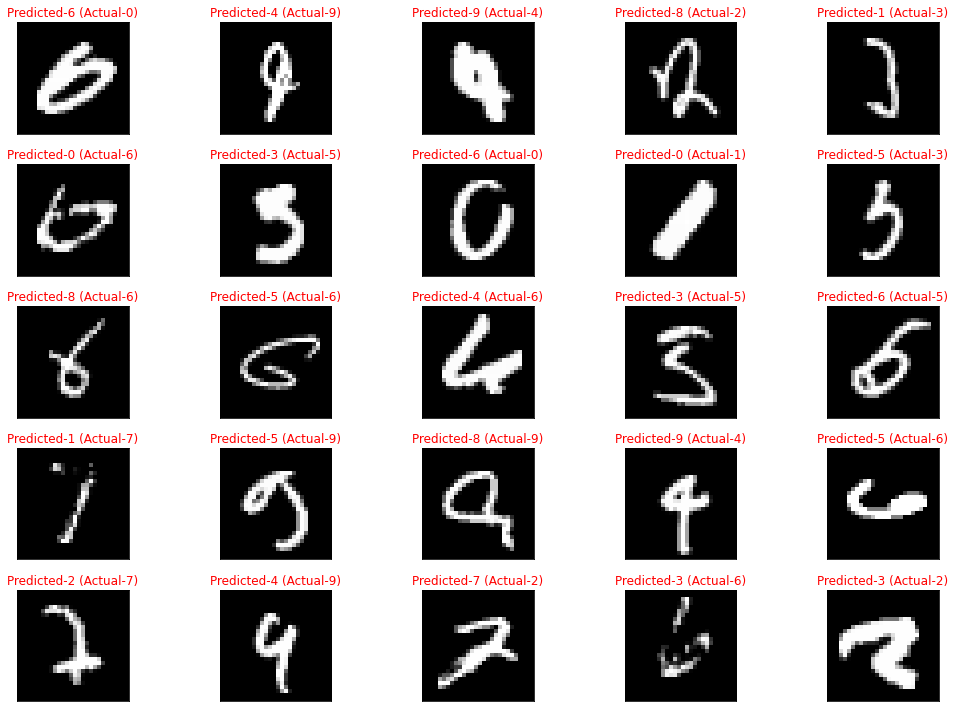

In [14]:
model.cpu()
fig = plt.figure(figsize = (16, 10))

c = 0
dataiter = iter(test_loader)

while c < misclassified_num:
  images, labels = dataiter.next()
  output = model(images)
  _, preds = torch.max(output, 1)
  for idx in range(images.shape[0]):
    if preds[idx] != labels[idx]:
      ax = fig.add_subplot(5, 5, c+1, xticks=[], yticks=[])
      c += 1
      ax.imshow(images[idx].squeeze(), cmap = 'gray')
      fig.tight_layout()
      ax.set_title("Predicted-{} (Actual-{})".format(str(preds[idx].item()), str(labels[idx].item())), color="red")
      if c == misclassified_num:
        break
  fig.savefig(filepath + "misclassified_without_L1_L2.png")

### 2. With L1

In [15]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

regularizer = 'L1'

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = momentum)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    print('lamda1 :', lamda1)
    train(model, device, train_loader, optimizer, epoch, regularizer=regularizer, lamda1 = lamda1) 
    test(model, device, test_loader)

test_loss_l1 = copy.deepcopy(test_losses)
test_acc_l1 = copy.deepcopy(test_acc)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0
lamda1 : 1e-06


Loss=0.1448439657688141 Batch_id=468 Accuracy=84.37: 100%|██████████| 469/469 [00:15<00:00, 30.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0914, Accuracy: 9797/10000 (97.97%)

EPOCH: 1
lamda1 : 1e-06


Loss=0.040757935494184494 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:15<00:00, 29.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0518, Accuracy: 9851/10000 (98.51%)

EPOCH: 2
lamda1 : 1e-06


Loss=0.028350405395030975 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:15<00:00, 30.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9873/10000 (98.73%)

EPOCH: 3
lamda1 : 1e-06


Loss=0.07544999569654465 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:15<00:00, 29.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9907/10000 (99.07%)

EPOCH: 4
lamda1 : 1e-06


Loss=0.06128354370594025 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:16<00:00, 29.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9910/10000 (99.10%)

EPOCH: 5
lamda1 : 1e-06


Loss=0.035124603658914566 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:15<00:00, 30.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9909/10000 (99.09%)

EPOCH: 6
lamda1 : 1e-06


Loss=0.05574836954474449 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:15<00:00, 29.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9917/10000 (99.17%)

EPOCH: 7
lamda1 : 1e-06


Loss=0.02547411248087883 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:15<00:00, 29.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9928/10000 (99.28%)

EPOCH: 8
lamda1 : 1e-06


Loss=0.025457054376602173 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:15<00:00, 29.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9924/10000 (99.24%)

EPOCH: 9
lamda1 : 1e-06


Loss=0.025998618453741074 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:15<00:00, 29.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9928/10000 (99.28%)

EPOCH: 10
lamda1 : 1e-06


Loss=0.020744796842336655 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 30.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9939/10000 (99.39%)

EPOCH: 11
lamda1 : 1e-06


Loss=0.04073652997612953 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:15<00:00, 29.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9931/10000 (99.31%)

EPOCH: 12
lamda1 : 1e-06


Loss=0.026421181857585907 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:15<00:00, 30.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9913/10000 (99.13%)

EPOCH: 13
lamda1 : 1e-06


Loss=0.04101593419909477 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:15<00:00, 29.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9935/10000 (99.35%)

EPOCH: 14
lamda1 : 1e-06


Loss=0.019772961735725403 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:15<00:00, 29.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9913/10000 (99.13%)

EPOCH: 15
lamda1 : 1e-06


Loss=0.08633673191070557 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:15<00:00, 30.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9931/10000 (99.31%)

EPOCH: 16
lamda1 : 1e-06


Loss=0.015774499624967575 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:15<00:00, 29.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9931/10000 (99.31%)

EPOCH: 17
lamda1 : 1e-06


Loss=0.08031642436981201 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:15<00:00, 30.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9938/10000 (99.38%)

EPOCH: 18
lamda1 : 1e-06


Loss=0.07239239662885666 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 29.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9932/10000 (99.32%)

EPOCH: 19
lamda1 : 1e-06


Loss=0.012364552356302738 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:15<00:00, 29.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9923/10000 (99.23%)

EPOCH: 20
lamda1 : 1e-06


Loss=0.05491326376795769 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 29.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9942/10000 (99.42%)

EPOCH: 21
lamda1 : 1e-06


Loss=0.026240793988108635 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:15<00:00, 30.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9939/10000 (99.39%)

EPOCH: 22
lamda1 : 1e-06


Loss=0.01915036328136921 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:15<00:00, 29.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9943/10000 (99.43%)

EPOCH: 23
lamda1 : 1e-06


Loss=0.039268821477890015 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:15<00:00, 30.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9939/10000 (99.39%)

EPOCH: 24
lamda1 : 1e-06


Loss=0.04248987138271332 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:15<00:00, 30.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9933/10000 (99.33%)

EPOCH: 25
lamda1 : 1e-06


Loss=0.06314250826835632 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:15<00:00, 29.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9938/10000 (99.38%)

EPOCH: 26
lamda1 : 1e-06


Loss=0.013444177806377411 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:15<00:00, 30.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9941/10000 (99.41%)

EPOCH: 27
lamda1 : 1e-06


Loss=0.022239331156015396 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:15<00:00, 29.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9941/10000 (99.41%)

EPOCH: 28
lamda1 : 1e-06


Loss=0.017308998852968216 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:15<00:00, 29.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9941/10000 (99.41%)

EPOCH: 29
lamda1 : 1e-06


Loss=0.0353795625269413 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:15<00:00, 29.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9952/10000 (99.52%)

EPOCH: 30
lamda1 : 1e-06


Loss=0.0228554867208004 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:15<00:00, 29.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9944/10000 (99.44%)

EPOCH: 31
lamda1 : 1e-06


Loss=0.04244652017951012 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:15<00:00, 29.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9941/10000 (99.41%)

EPOCH: 32
lamda1 : 1e-06


Loss=0.013741588220000267 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:15<00:00, 29.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9942/10000 (99.42%)

EPOCH: 33
lamda1 : 1e-06


Loss=0.06236931309103966 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:15<00:00, 30.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9934/10000 (99.34%)

EPOCH: 34
lamda1 : 1e-06


Loss=0.054334018379449844 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:15<00:00, 30.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9946/10000 (99.46%)

EPOCH: 35
lamda1 : 1e-06


Loss=0.08673412352800369 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:15<00:00, 30.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9945/10000 (99.45%)

EPOCH: 36
lamda1 : 1e-06


Loss=0.012995876371860504 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:15<00:00, 29.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9940/10000 (99.40%)

EPOCH: 37
lamda1 : 1e-06


Loss=0.01832929626107216 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:15<00:00, 30.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9937/10000 (99.37%)

EPOCH: 38
lamda1 : 1e-06


Loss=0.02678889036178589 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:15<00:00, 30.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9942/10000 (99.42%)

EPOCH: 39
lamda1 : 1e-06


Loss=0.040803212672472 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:15<00:00, 31.08it/s]



Test set: Average loss: 0.0183, Accuracy: 9940/10000 (99.40%)



#### Misclassified Images

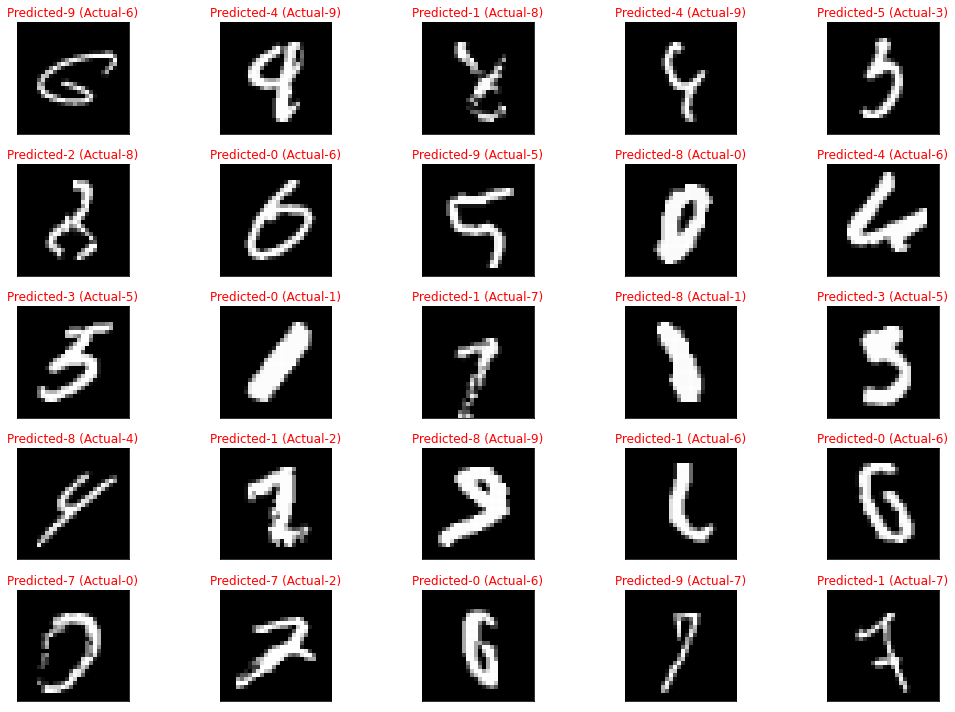

In [16]:
model.cpu()
fig = plt.figure(figsize = (16, 10))

c = 0
dataiter = iter(test_loader)

while c < misclassified_num:
  images, labels = dataiter.next()
  output = model(images)
  _, preds = torch.max(output, 1)
  for idx in range(images.shape[0]):
    if preds[idx] != labels[idx]:
      ax = fig.add_subplot(5, 5, c+1, xticks=[], yticks=[])
      c += 1
      ax.imshow(images[idx].squeeze(), cmap = 'gray')
      fig.tight_layout()
      ax.set_title("Predicted-{} (Actual-{})".format(str(preds[idx].item()), str(labels[idx].item())), color="red")
      if c == misclassified_num:
        break
  fig.savefig(filepath + "misclassified_with_L1.png")

### 3. With L2

In [17]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

regularizer = 'L2'

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = momentum)

for epoch in range(EPOCHS):
    print("EPOCH :", epoch)
    print('lamda2 :', lamda2)
    train(model, device, train_loader, optimizer, epoch, regularizer = regularizer,lamda2 = lamda2) 
    test(model, device, test_loader)

test_loss_l2 = copy.copy(test_losses)
test_acc_l2 = copy.copy(test_acc)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH : 0
lamda2 : 3e-05


Loss=0.13851648569107056 Batch_id=468 Accuracy=82.30: 100%|██████████| 469/469 [00:15<00:00, 30.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0927, Accuracy: 9773/10000 (97.73%)

EPOCH : 1
lamda2 : 3e-05


Loss=0.07655757665634155 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:15<00:00, 30.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0629, Accuracy: 9837/10000 (98.37%)

EPOCH : 2
lamda2 : 3e-05


Loss=0.1462557315826416 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:15<00:00, 31.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Accuracy: 9871/10000 (98.71%)

EPOCH : 3
lamda2 : 3e-05


Loss=0.049576207995414734 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:14<00:00, 31.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9912/10000 (99.12%)

EPOCH : 4
lamda2 : 3e-05


Loss=0.06783761829137802 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:15<00:00, 30.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9911/10000 (99.11%)

EPOCH : 5
lamda2 : 3e-05


Loss=0.06590405851602554 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:15<00:00, 30.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9905/10000 (99.05%)

EPOCH : 6
lamda2 : 3e-05


Loss=0.04969242960214615 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:14<00:00, 31.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9925/10000 (99.25%)

EPOCH : 7
lamda2 : 3e-05


Loss=0.02903013676404953 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:14<00:00, 31.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9917/10000 (99.17%)

EPOCH : 8
lamda2 : 3e-05


Loss=0.05161723122000694 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 31.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9914/10000 (99.14%)

EPOCH : 9
lamda2 : 3e-05


Loss=0.05433978512883186 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:14<00:00, 31.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9939/10000 (99.39%)

EPOCH : 10
lamda2 : 3e-05


Loss=0.02710316702723503 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:14<00:00, 31.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9926/10000 (99.26%)

EPOCH : 11
lamda2 : 3e-05


Loss=0.06103209778666496 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:14<00:00, 31.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9926/10000 (99.26%)

EPOCH : 12
lamda2 : 3e-05


Loss=0.05783826857805252 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:14<00:00, 32.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9931/10000 (99.31%)

EPOCH : 13
lamda2 : 3e-05


Loss=0.021109361201524734 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:14<00:00, 32.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9930/10000 (99.30%)

EPOCH : 14
lamda2 : 3e-05


Loss=0.021933328360319138 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 31.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9932/10000 (99.32%)

EPOCH : 15
lamda2 : 3e-05


Loss=0.04738252982497215 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:14<00:00, 31.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9925/10000 (99.25%)

EPOCH : 16
lamda2 : 3e-05


Loss=0.02542722038924694 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 32.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9947/10000 (99.47%)

EPOCH : 17
lamda2 : 3e-05


Loss=0.02386503480374813 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 32.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9928/10000 (99.28%)

EPOCH : 18
lamda2 : 3e-05


Loss=0.04549490660429001 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:14<00:00, 32.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9928/10000 (99.28%)

EPOCH : 19
lamda2 : 3e-05


Loss=0.030954066663980484 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 32.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9939/10000 (99.39%)

EPOCH : 20
lamda2 : 3e-05


Loss=0.02603803016245365 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 31.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9939/10000 (99.39%)

EPOCH : 21
lamda2 : 3e-05


Loss=0.04753652960062027 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 32.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9950/10000 (99.50%)

EPOCH : 22
lamda2 : 3e-05


Loss=0.03333485871553421 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 31.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9943/10000 (99.43%)

EPOCH : 23
lamda2 : 3e-05


Loss=0.0212104432284832 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 31.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9940/10000 (99.40%)

EPOCH : 24
lamda2 : 3e-05


Loss=0.07432533800601959 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:14<00:00, 31.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9930/10000 (99.30%)

EPOCH : 25
lamda2 : 3e-05


Loss=0.15815962851047516 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:14<00:00, 31.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9938/10000 (99.38%)

EPOCH : 26
lamda2 : 3e-05


Loss=0.026330145075917244 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:15<00:00, 31.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9936/10000 (99.36%)

EPOCH : 27
lamda2 : 3e-05


Loss=0.02638091892004013 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:15<00:00, 30.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9937/10000 (99.37%)

EPOCH : 28
lamda2 : 3e-05


Loss=0.02984681725502014 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:15<00:00, 30.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9940/10000 (99.40%)

EPOCH : 29
lamda2 : 3e-05


Loss=0.023153237998485565 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:15<00:00, 30.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9942/10000 (99.42%)

EPOCH : 30
lamda2 : 3e-05


Loss=0.05521829426288605 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:15<00:00, 30.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9937/10000 (99.37%)

EPOCH : 31
lamda2 : 3e-05


Loss=0.027688905596733093 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:15<00:00, 30.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9947/10000 (99.47%)

EPOCH : 32
lamda2 : 3e-05


Loss=0.041314803063869476 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:15<00:00, 30.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9947/10000 (99.47%)

EPOCH : 33
lamda2 : 3e-05


Loss=0.024422623217105865 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:15<00:00, 29.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9948/10000 (99.48%)

EPOCH : 34
lamda2 : 3e-05


Loss=0.02486295811831951 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:15<00:00, 29.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9936/10000 (99.36%)

EPOCH : 35
lamda2 : 3e-05


Loss=0.05150509998202324 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:15<00:00, 30.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9944/10000 (99.44%)

EPOCH : 36
lamda2 : 3e-05


Loss=0.07244322448968887 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:15<00:00, 30.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9942/10000 (99.42%)

EPOCH : 37
lamda2 : 3e-05


Loss=0.020896028727293015 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:15<00:00, 30.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9951/10000 (99.51%)

EPOCH : 38
lamda2 : 3e-05


Loss=0.02258903719484806 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:15<00:00, 29.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9945/10000 (99.45%)

EPOCH : 39
lamda2 : 3e-05


Loss=0.05415983870625496 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:15<00:00, 29.79it/s]



Test set: Average loss: 0.0168, Accuracy: 9939/10000 (99.39%)



#### Misclassified Images

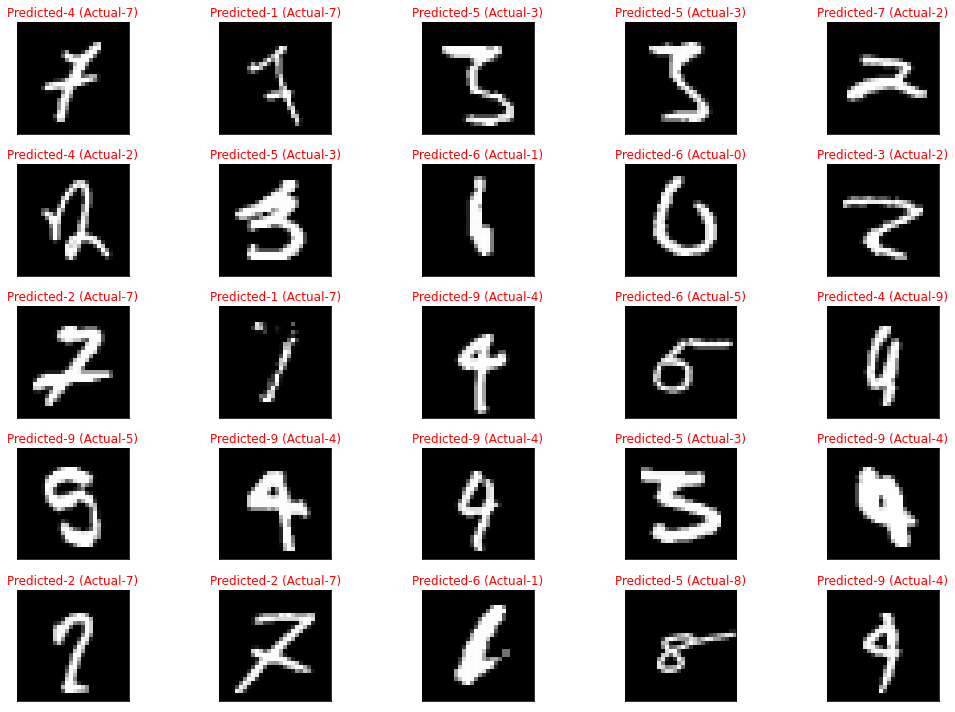

In [18]:
model.cpu()
fig = plt.figure(figsize = (16, 10))

c = 0
dataiter = iter(test_loader)

while c < misclassified_num:
  images, labels = dataiter.next()
  output = model(images)
  _, preds = torch.max(output, 1)
  for idx in range(images.shape[0]):
    if preds[idx] != labels[idx]:
      ax = fig.add_subplot(5, 5, c+1, xticks=[], yticks=[])
      c += 1
      ax.imshow(images[idx].squeeze(), cmap = 'gray')
      fig.tight_layout()
      ax.set_title("Predicted-{} (Actual-{})".format(str(preds[idx].item()), str(labels[idx].item())), color="red")
      if c == misclassified_num:
        break
  fig.savefig(filepath + "misclassified_with_L2.png")

### With L1 and L2

In [19]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

regularizer = 'Both'

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    print("lamda1:", lamda1)
    print("lamda2:", lamda2)
    train(model, device, train_loader, optimizer, epoch, regularizer=regularizer, lamda1 = lamda1, lamda2 = lamda2)
    test(model, device, test_loader)

test_loss_both = copy.copy(test_losses)
test_acc_both = copy.copy(test_acc)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0
lamda1: 1e-06
lamda2: 3e-05


Loss=0.19584646821022034 Batch_id=468 Accuracy=81.14: 100%|██████████| 469/469 [00:17<00:00, 26.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0862, Accuracy: 9794/10000 (97.94%)

EPOCH: 1
lamda1: 1e-06
lamda2: 3e-05


Loss=0.07131695747375488 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:17<00:00, 26.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0624, Accuracy: 9843/10000 (98.43%)

EPOCH: 2
lamda1: 1e-06
lamda2: 3e-05


Loss=0.07597518712282181 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:17<00:00, 26.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9902/10000 (99.02%)

EPOCH: 3
lamda1: 1e-06
lamda2: 3e-05


Loss=0.06055944412946701 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:17<00:00, 26.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9906/10000 (99.06%)

EPOCH: 4
lamda1: 1e-06
lamda2: 3e-05


Loss=0.03641064092516899 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:17<00:00, 26.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9910/10000 (99.10%)

EPOCH: 5
lamda1: 1e-06
lamda2: 3e-05


Loss=0.10919918119907379 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:17<00:00, 26.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9908/10000 (99.08%)

EPOCH: 6
lamda1: 1e-06
lamda2: 3e-05


Loss=0.07113955169916153 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:17<00:00, 26.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9913/10000 (99.13%)

EPOCH: 7
lamda1: 1e-06
lamda2: 3e-05


Loss=0.056424934417009354 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:17<00:00, 26.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9930/10000 (99.30%)

EPOCH: 8
lamda1: 1e-06
lamda2: 3e-05


Loss=0.04768851771950722 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:17<00:00, 26.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9913/10000 (99.13%)

EPOCH: 9
lamda1: 1e-06
lamda2: 3e-05


Loss=0.03541172295808792 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:17<00:00, 26.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9926/10000 (99.26%)

EPOCH: 10
lamda1: 1e-06
lamda2: 3e-05


Loss=0.07868444919586182 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:17<00:00, 26.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9924/10000 (99.24%)

EPOCH: 11
lamda1: 1e-06
lamda2: 3e-05


Loss=0.03521924465894699 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:17<00:00, 26.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9926/10000 (99.26%)

EPOCH: 12
lamda1: 1e-06
lamda2: 3e-05


Loss=0.04178568348288536 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:17<00:00, 27.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9942/10000 (99.42%)

EPOCH: 13
lamda1: 1e-06
lamda2: 3e-05


Loss=0.03206523880362511 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:17<00:00, 26.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9921/10000 (99.21%)

EPOCH: 14
lamda1: 1e-06
lamda2: 3e-05


Loss=0.028274772688746452 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:17<00:00, 26.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9926/10000 (99.26%)

EPOCH: 15
lamda1: 1e-06
lamda2: 3e-05


Loss=0.06754544377326965 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:17<00:00, 26.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9920/10000 (99.20%)

EPOCH: 16
lamda1: 1e-06
lamda2: 3e-05


Loss=0.03409850597381592 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:17<00:00, 27.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9930/10000 (99.30%)

EPOCH: 17
lamda1: 1e-06
lamda2: 3e-05


Loss=0.05743008479475975 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:17<00:00, 26.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9931/10000 (99.31%)

EPOCH: 18
lamda1: 1e-06
lamda2: 3e-05


Loss=0.03344891592860222 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:17<00:00, 26.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9940/10000 (99.40%)

EPOCH: 19
lamda1: 1e-06
lamda2: 3e-05


Loss=0.13436223566532135 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:17<00:00, 26.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9932/10000 (99.32%)

EPOCH: 20
lamda1: 1e-06
lamda2: 3e-05


Loss=0.07669372856616974 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:17<00:00, 26.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9929/10000 (99.29%)

EPOCH: 21
lamda1: 1e-06
lamda2: 3e-05


Loss=0.02758733555674553 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:17<00:00, 26.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9935/10000 (99.35%)

EPOCH: 22
lamda1: 1e-06
lamda2: 3e-05


Loss=0.041377756744623184 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:17<00:00, 26.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9938/10000 (99.38%)

EPOCH: 23
lamda1: 1e-06
lamda2: 3e-05


Loss=0.06953917443752289 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:17<00:00, 26.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9939/10000 (99.39%)

EPOCH: 24
lamda1: 1e-06
lamda2: 3e-05


Loss=0.06521815806627274 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:17<00:00, 26.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9924/10000 (99.24%)

EPOCH: 25
lamda1: 1e-06
lamda2: 3e-05


Loss=0.05852267146110535 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:17<00:00, 26.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9930/10000 (99.30%)

EPOCH: 26
lamda1: 1e-06
lamda2: 3e-05


Loss=0.051245708018541336 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:17<00:00, 26.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9930/10000 (99.30%)

EPOCH: 27
lamda1: 1e-06
lamda2: 3e-05


Loss=0.02986997738480568 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:17<00:00, 26.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9932/10000 (99.32%)

EPOCH: 28
lamda1: 1e-06
lamda2: 3e-05


Loss=0.04308890923857689 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:17<00:00, 26.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9931/10000 (99.31%)

EPOCH: 29
lamda1: 1e-06
lamda2: 3e-05


Loss=0.06427734345197678 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:17<00:00, 26.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9948/10000 (99.48%)

EPOCH: 30
lamda1: 1e-06
lamda2: 3e-05


Loss=0.04549448937177658 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:17<00:00, 26.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9941/10000 (99.41%)

EPOCH: 31
lamda1: 1e-06
lamda2: 3e-05


Loss=0.030057189986109734 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:17<00:00, 26.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9929/10000 (99.29%)

EPOCH: 32
lamda1: 1e-06
lamda2: 3e-05


Loss=0.03176546469330788 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:17<00:00, 26.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9942/10000 (99.42%)

EPOCH: 33
lamda1: 1e-06
lamda2: 3e-05


Loss=0.036612629890441895 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:17<00:00, 26.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9934/10000 (99.34%)

EPOCH: 34
lamda1: 1e-06
lamda2: 3e-05


Loss=0.07298347353935242 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:17<00:00, 26.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9952/10000 (99.52%)

EPOCH: 35
lamda1: 1e-06
lamda2: 3e-05


Loss=0.03244972229003906 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:17<00:00, 26.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9946/10000 (99.46%)

EPOCH: 36
lamda1: 1e-06
lamda2: 3e-05


Loss=0.03743208572268486 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:17<00:00, 26.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9947/10000 (99.47%)

EPOCH: 37
lamda1: 1e-06
lamda2: 3e-05


Loss=0.026596421375870705 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:17<00:00, 26.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9937/10000 (99.37%)

EPOCH: 38
lamda1: 1e-06
lamda2: 3e-05


Loss=0.037709347903728485 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:17<00:00, 26.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9940/10000 (99.40%)

EPOCH: 39
lamda1: 1e-06
lamda2: 3e-05


Loss=0.024671506136655807 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:17<00:00, 26.40it/s]



Test set: Average loss: 0.0211, Accuracy: 9936/10000 (99.36%)



#### Misclassified Images

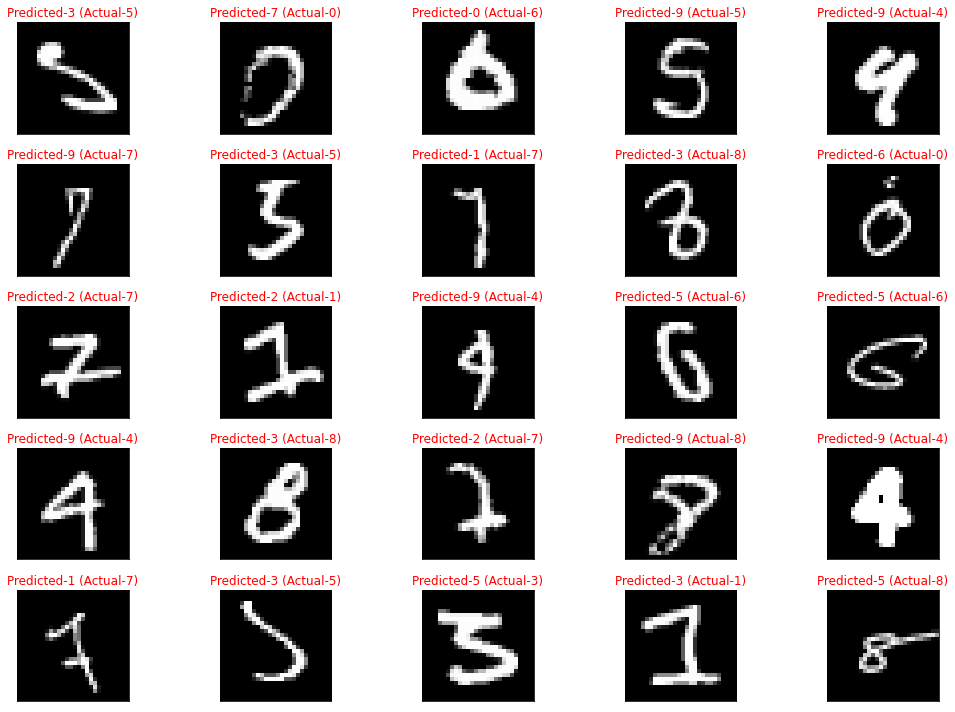

In [20]:
model.cpu()
fig = plt.figure(figsize = (16, 10))

c = 0
dataiter = iter(test_loader)

while c < misclassified_num:
  images, labels = dataiter.next()
  output = model(images)
  _, preds = torch.max(output, 1)
  for idx in range(images.shape[0]):
    if preds[idx] != labels[idx]:
      ax = fig.add_subplot(5, 5, c+1, xticks=[], yticks=[])
      c += 1
      ax.imshow(images[idx].squeeze(), cmap = 'gray')
      fig.tight_layout()
      ax.set_title("Predicted-{} (Actual-{})".format(str(preds[idx].item()), str(labels[idx].item())), color="red")
      if c == misclassified_num:
        break
  fig.savefig(filepath + "misclassified_with_L1_L2.png")

## Loss and Accuracy

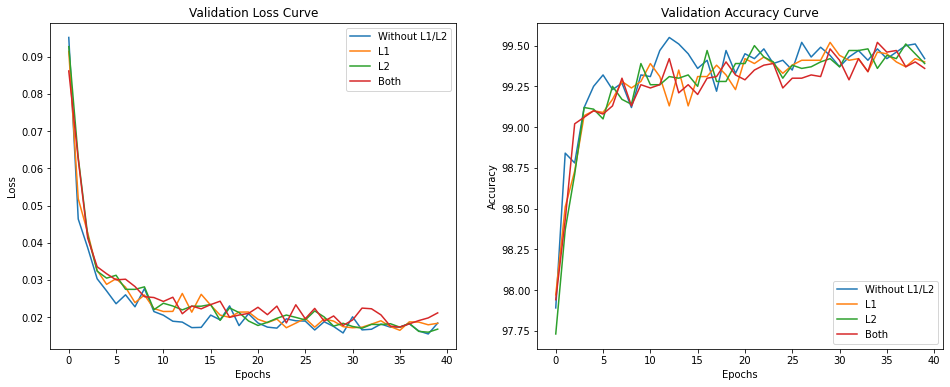

In [21]:
fig, axs = plt.subplots(1, 2, figsize = (16, 6))
axs[0].plot(test_loss_none)
axs[0].plot(test_loss_l1)
axs[0].plot(test_loss_l2)
axs[0].plot(test_loss_both)
axs[0].set_title('Validation Loss Curve')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Without L1/L2', 'L1', 'L2', 'Both'])
axs[1].plot(test_acc_none)
axs[1].plot(test_acc_l1)
axs[1].plot(test_acc_l2)
axs[1].plot(test_acc_both)
axs[1].set_title('Validation Accuracy Curve')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Without L1/L2', 'L1', 'L2', 'Both'])
fig.savefig(filepath + 'validation_loss_accuracy.png');

## S6 - Solution Quiz:
Explain your observation w.r.t L1 and L2's performance in the regularization of your model.

## Quiz 6:
1. Image Normalization and Image Equalization are same things. True or False?
  
  False

2. Image normalization helps
 
 * the model to handle different variations of images
 * train the network to handle image covariate shift

 3. Batch Normalization

  * solves internal covariate shift
  * reduces the need for highly tuned hyperparameters.
  * helps train deeper networks
  * helps train networks faster

4. A layer has 32 channels. It will
 
 * have 32 means and 32 variance

5. Bias

 * gets subtracted out when BN is used

6. If BN is used, which of the following are True?
 
 * larger learning rate can be used
 * kernel values will be smaller
 * gradient flow will not diminish a lot in backprop
 * per epoch would be slightly slower

7. If we use regularization (L1/L2):
 
 * we can solve over-fitting
 * kernel values are going to be close to zero or small

8. If we create our data set in such a way that our images are automatically normalized then would we need BN?

 * Yes, BN has more to do with features than pixel intensities, and image normalization does not guarantee that all features would have normalized values.

9. Later we'd see that we can add as well as concantenate the channels. Which statement is True?

 * BN can be done either before or after adding or concatenating the channels. It doesn't matter!


### That's all Folks!